In [1]:
from functools import partial
from glob import glob
import os
import time
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm, tqdm_notebook

# from dstorch.data import calc_data_stats

%matplotlib inline

# USE_GPUS = '1'
USE_GPUS = '1, 2, 3'
os.environ['CUDA_VISIBLE_DEVICES'] = USE_GPUS

In [2]:
train_path = './data/train/'
val_path = './data/valid/'

In [12]:
class DogsCatsDataset(Dataset):
    def __init__(self, data_path, category=None, resize=500, input_size=224, 
                 crop_ratio=0.25, degenerate=True, color_drop=True, transform=None):
        self.data_path = data_path
        self.category = category
        self.resize = resize
        self.input_size = input_size
        self.crop_ratio = crop_ratio
        self.degenerate = degenerate
        self.color_drop = color_drop
        
        self.transform = transform
        
        self.dog_filename_list = glob(self.data_path + 'dogs/*.jpg')
        self.cat_filename_list = glob(self.data_path + 'cats/*.jpg')
        
    def __getitem__(self, index):
        dog_filename, cat_filename = self.dog_filename_list[index], self.cat_filename_list[index]
        
        dog_img, cat_img = cv2.imread(dog_filename), cv2.imread(cat_filename)
        dog_img, cat_img = cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB), cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
        
        if self.category is not None:
            img, label = dog_img, 1 if self.category == 'dog' else cat_img, 0
        
        else:
            choice = np.random.choice([0, 1])
            
            img = dog_img if choice else cat_img
            label = choice
           
        # Crop largest square image
        img = self.crop_center(img, 1)        
        # Resize image
        img = cv2.resize(img, (self.resize, self.resize))
        # Get center image
        img_center = self.crop_center(img, self.crop_ratio)
        # Get context image and idx
        img_context, idx = self.get_context_img(img)
        # Resize to 224
        img_center = cv2.resize(img_center, (self.input_size, self.input_size))
        img_context = cv2.resize(img_context, (self.input_size, self.input_size))
        
        if self.degenerate:
            img_center, img_context = self.degenerate_img(img_center), self.degenerate_img(img_context)
            
        if self.color_drop:
            img_center, img_context = self.color_drop_img(img_center), self.color_drop_img(img_context)
            
        # Convert to torch tensor
        img_center = torch.from_numpy(np.rollaxis(img_center / 255, 2).copy()).float()
        img_context = torch.from_numpy(np.rollaxis(img_context / 255, 2).copy()).float()
        
        if self.transform is not None:
            img_center = self.transform(img_center)
            img_context = self.transform(img_context)
            
#         print(img_center.shape, img_context.shape)
        return (img_center, img_context), idx, label
    
    def __len__(self):
        
        return len(self.dog_filename_list)
    
    @staticmethod
    def degenerate_img(img, low=0.1):
        img = img.copy()
        
        input_size = img.shape[0]

        p = np.random.uniform(low=low, size=1)        
        degen_size = int(p * input_size)

        img = cv2.resize(img, (degen_size, degen_size))
        img = cv2.resize(img, (input_size, input_size))

        return img
        
    @staticmethod
    def color_drop_img(img, std=0.01):
        img = img.copy()

        color_set = {0, 1, 2}
        drop_set = set(np.random.choice((0, 1, 2), size=2, replace=False).tolist())

        idx_remained = next(iter(color_set - drop_set))

        color_std = img[:, :, idx_remained].std() * std

        for color_idx in drop_set:
            mean = img[:, :, color_idx].mean()
            channel_data = np.random.normal(mean, color_std, size=[img.shape[0], img.shape[1]])
            img[:, :, color_idx] = channel_data

        return img

    @staticmethod
    def crop_center(img, crop_ratio):       
        x, y, _ = img.shape

        max_size = min(x, y)
        max_size = int(max_size * crop_ratio)

        x_start = max(x // 2 - (max_size // 2), 0)
        y_start = max(y // 2 - (max_size // 2), 0)

        x_end = x_start + max_size
        y_end = y_start + max_size

        img = img[x_start:x_end, y_start:y_end, :]

        return img
    
    def get_context_img(self, img):
        x, y, _ = img.shape

        max_size = min(x, y)
        max_size = int(max_size * self.crop_ratio)
        gap_size = max_size // 4
        
        x_center, y_center = x // 2, y // 2
        
        candidate_dict = {
                          0: (-1, -1),
                          1: (-1, 0),
                          2: (-1, 1),
                          3: (0, 1),
                          4: (1, 1),
                          5: (1, 0),
                          6: (1, -1),
                          7: (0, -1)
                         }
        
        idx = int(np.random.choice(range(len(candidate_dict))))
        context_factor = 150 + int(np.random.normal(0, 7))
        
        x_compare = x_center + context_factor * candidate_dict[idx][0]    
        y_compare = y_center + context_factor * candidate_dict[idx][1]
        
        x_compare_start, y_compare_start = x_compare - max_size // 2, y_compare - max_size // 2
        x_compare_end, y_compare_end = x_compare_start + max_size, y_compare_start + max_size
        
#         print("x_center, y_center: {}".format((x_center, y_center)))
#         print("x_compare, y_compare: {}".format((y_compare, y_compare)))
#         print("Idx: {}".format(idx))
#         print(x_compare_start, x_compare_end, y_compare_start, y_compare_end)
        
        return img[x_compare_start:x_compare_end, y_compare_start:y_compare_end, :], idx    

In [13]:
# data_path_list = glob(train_path + 'dogs/*.jpg') + glob(train_path + 'cats/*.jpg')

# bgr2rgb = partial(cv2.cvtColor, code=cv2.COLOR_BGR2RGB)

# img_list = list(map(bgr2rgb, [cv2.imread(path) for path in tqdm_notebook(data_path_list)]))

In [14]:
# row_list, col_list = [], []

# for img in img_list:
#     num_rows, num_cols, num_channels = img.shape
    
#     row_list.append(num_rows)
#     col_list.append(num_cols)
        
# print("Rows: Max: {}, Min: {}, Median: {}".format(np.max(row_list), np.min(row_list), 
#                                                   np.median(row_list)))
# print("Cols: Max: {}, Min: {}, Median: {}".format(np.max(col_list), np.min(col_list), 
#                                                   np.median(col_list)))


In [15]:
batch_size = 32 * len(USE_GPUS.split(','))

kwargs = {'num_workers': len(USE_GPUS.split(',')) * 4, 'pin_memory': False} \
          if torch.cuda.is_available() else {}

# mean_tuple = (0.4901, 0.4546, 0.4159)
# std_tuple = (0.1171, 0.1086, 0.1122)

# transform_train = transforms.Compose([
# #                                       transforms.RandomHorizontalFlip(),
#                                       transforms.Normalize(mean_tuple, std_tuple)
#                                      ])

# transform_val = transforms.Compose([
#                                      transforms.Normalize(mean_tuple, std_tuple)
#                                     ])

training_set = DogsCatsDataset(train_path)
validation_set = DogsCatsDataset(val_path)

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, **kwargs)
valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, **kwargs)

In [16]:
# def calc_data_stats(data_loader, dtype='image', repeat=10):
#     batch_size = data_loader.batch_size

#     sample_size = 0
#     mean_list = []
    
#     for _ in tqdm_notebook(range(repeat)):
#         for data in data_loader:
#             x, y = data
#             x = x.view(x.size(0), x.size(1), -1)
#             mean_list.append(x.mean(2).mean(0))

#             sample_size += x.shape[0] 
        
#     mean = torch.stack(mean_list).mean(dim=0)
#     se = torch.stack(mean_list).std(dim=0)
#     std = se * torch.sqrt(torch.tensor(float(batch_size)))

#     print("=============================")
#     print("Dataset size: {}".format(sample_size))
#     print("Batch size: {}".format(batch_size))
#     print("Mean: {}".format(mean))
#     print("STD: {}".format(std))

#     return mean, std

In [17]:
# calc_data_stats(train_loader)

In [18]:
class ContextNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.resnet50 = nn.Sequential(*list(models.resnet50(pretrained=pretrained).children())[:-1])
        
        self.classifier = nn.Sequential(
                                        nn.Linear(2048, 2048),
                                        nn.Dropout(0.5),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(2048, 8),
                                        nn.LogSoftmax(dim=1)
        )
               
    def forward(self, x):
        img_center, img_compare = x
        
        img_center = self.resnet50(img_center)
        img_compare = self.resnet50(img_compare)
        
        img_flat_size = img_center.size(1) * img_center.size(2) * img_center.size(3)
        
        img_center = img_center.view(-1, img_flat_size)
        img_compare = img_compare.view(-1, img_flat_size)
        
        img = img_center + img_compare
        
        output = self.classifier(img)
        
        
        return output

In [19]:
model = ContextNet(True)
model = nn.DataParallel(model)

In [ ]:
loss_list, loss_test_list = [], []

epochs = 5000
lr = 0.0001

loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0003)

start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    
    if torch.cuda.is_available():
        model = model.cuda()

        if not next(model.parameters()).is_cuda:
            raise TypeError("model.cuda() is not working!")

    else:
        model = model.cpu()  

    for batch_idx, (data, idx, _) in enumerate(train_loader):
        img_center, img_context = data
        
        if torch.cuda.is_available():
            img_center, img_context = img_center.cuda(non_blocking=True), img_context.cuda(non_blocking=True)
            idx = idx.cuda(non_blocking=True)
        else:
            img_center, img_context, idx = img_center.cpu(), img_context.cpu(), idx.cpu()

        img_center, img_context, idx = Variable(img_center), Variable(img_context), Variable(idx)
    
        optimizer.zero_grad()
        
        output = model((img_center, img_context))
        
        loss = loss_func(output, idx)
        
        loss.backward()
        optimizer.step()
                
        if batch_idx % 20 == 0:
            print("Epoch: {0}, It: {1}, Loss: {2:.4f}".format(epoch, batch_idx, loss))
     
    model.eval()
        
    num_rows_train = 0
    correct_train = 0
    
    # Training set
    with torch.no_grad():
        for batch_idx, (data, idx, _) in enumerate(train_loader):
            img_center, img_context = data
            
            if torch.cuda.is_available():
                img_center, img_context = img_center.cuda(non_blocking=True), img_context.cuda(non_blocking=True)
                idx = idx.cuda(non_blocking=True)
            else:
                img_center, img_context = img_center.cpu(), img_context.cpu(), idx.cpu()

            img_center, img_context, idx = Variable(img_center), Variable(img_context), Variable(idx)
            num_rows_train += img_center.size(0)
            
            output = model((img_center, img_context))
            loss = loss_func(output, idx)
            
            pred = output.data.max(1, keepdim=True)[1]
            correct_train += pred.eq(idx.data.view_as(pred)).cpu().sum()
            
            loss_list.append(loss.detach())
     
    num_rows = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, (data, idx, _) in enumerate(valid_loader):
            img_center, img_context = data
            
            if torch.cuda.is_available():
                img_center, img_context = img_center.cuda(non_blocking=True), img_context.cuda(non_blocking=True)
                idx = idx.cuda(non_blocking=True)
            else:
                img_center, img_context = img_center.cpu(), img_context.cpu(), idx.cpu()

            img_center, img_context, idx = Variable(img_center), Variable(img_context), Variable(idx)
            num_rows += img_center.size(0)
            
            output = model((img_center, img_context))
            loss_test = loss_func(output, idx)
            
            loss_test_list.append(loss_test)
            loss_test_mean = torch.mean(torch.stack(loss_test_list))
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(idx.data.view_as(pred)).cpu().sum()
    
    # Save model
    model_path = 'models/model_{}.pth'.format(epoch)
    torch.save(model.state_dict(), model_path)
    print("Model saved at {}".format(model_path))
    
    print("=====================================================================")
    print("Training set acc: {:.4f}%".format((100. * correct_train.item()) / num_rows_train))
    print("Loss: {0:.4f}, Test acc: {1:.4f}%".format(loss_test_mean, (100. * correct.item()) / num_rows))
    print("Epoch took {} seconds.".format(time.time() - epoch_start_time))
    print("=====================================================================")
        
print("Training took {} seconds\n".format(round(time.time() - start_time, 2)))

Epoch: 0, It: 0, Loss: 2.1958
Epoch: 0, It: 20, Loss: 2.1525
Epoch: 0, It: 40, Loss: 2.0550
Epoch: 0, It: 60, Loss: 2.1723
Epoch: 0, It: 80, Loss: 2.0437
Epoch: 0, It: 100, Loss: 2.0305
Model saved at models/model_0.pth
Training set acc: 17.0696%
Loss: 2.0960, Test acc: 19.4000%
Epoch took 281.90870547294617 seconds.
Epoch: 1, It: 0, Loss: 2.1116
Epoch: 1, It: 20, Loss: 1.9281
Epoch: 1, It: 40, Loss: 2.0452
Epoch: 1, It: 60, Loss: 2.1019
Epoch: 1, It: 80, Loss: 1.9187
Epoch: 1, It: 100, Loss: 1.8562
Model saved at models/model_1.pth
Training set acc: 23.0696%
Loss: 2.0219, Test acc: 24.8000%
Epoch took 281.18014097213745 seconds.
Epoch: 2, It: 0, Loss: 1.9608
Epoch: 2, It: 20, Loss: 1.8777
Epoch: 2, It: 40, Loss: 1.8708
Epoch: 2, It: 60, Loss: 1.9460
Epoch: 2, It: 80, Loss: 1.5092
Epoch: 2, It: 100, Loss: 1.8685


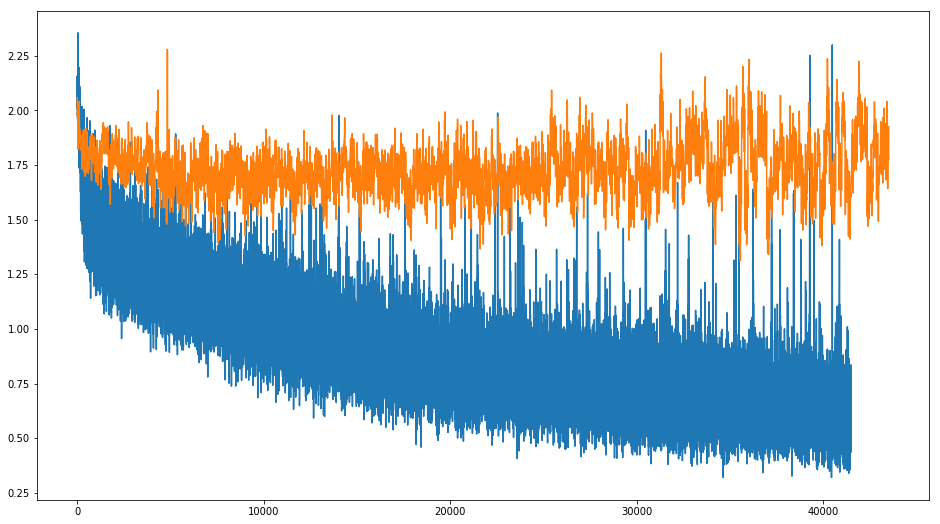

In [19]:
fig = plt.figure(figsize=(16, 9))

# Draw for training loss
plt.plot(range(len(loss_list)), loss_list, label="Training")
# Draw for test loss
plt.plot(range(len(loss_test_list)), loss_test_list, label="Test")
# Side info
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()

plt.show()
